### Figure 4 generation notebook for MERFISH single cell quality comparisons

In [1]:
import os
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import anndata
import scanpy
import string

mpl.rcParams.update(mpl.rcParamsDefault) #Reset rcParams to default
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']  # Colors in this style

# Plotting style function (run this before plotting the final figure)
def set_plotting_style():
    plt.style.use('seaborn-paper')
    plt.rc('axes', labelsize=12)
    plt.rc('axes', titlesize=12)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.rc('text.latex', preamble=r'\usepackage{sfmath}')
    plt.rc('xtick.major', pad=2)
    plt.rc('ytick.major', pad=2)
    plt.rc('mathtext', fontset='stixsans', sf='sansserif')
    plt.rc('figure', figsize=[10,9])
    plt.rc('svg', fonttype='none')

In [2]:
# Load postprocessed MERFISH and MACA results

# Define the path of the analyzed MERFISH data
dataPathPost = '../../../results'

# Define the experiments
experimentName = ['MsLiver_Cellbound_VZG116_V1_JH_09-18-2021', 
                  'MsKidney_CellBoundary_VZG116_111921']
prefixCountsFilter = ''
suffixCountsFilter = '_FilteredSingleCellCounts.h5ad'

VizgenCountsFilter = []

# QC filtering criteria
min_transcripts = 20
min_DAPI = 600
min_volume = 80
max_volume = 2000

for i in range(len(experimentName)):
    # Filtered counts per segmented cell
    VizgenCountsFilter.append(anndata.read_h5ad(os.path.join(dataPathPost, prefixCountsFilter, 
                                                        experimentName[i] + suffixCountsFilter)))

# Convert all gene names to lower case
for i in range(len(experimentName)):
    VizgenCountsFilter[i].var.index = VizgenCountsFilter[i].var.index.str.lower()
    
# Rename the 5 genes that are inconsistent with MACA (NOTE: MIR205HG doesn't seem to be in MACA at all)
rename_map = {'mir205hg':'4631405k08rik',
             'ackr1':'darc',
             'adgrl4':'eltd1',
             'cavin2':'sdpr',
             'jchain':'igj'}
for i in range(len(experimentName)):
    gene_list = list(VizgenCountsFilter[i].var.index)
    for j in range(len(gene_list)):
        if gene_list[j] in rename_map.keys():
            gene_list[j] = rename_map[gene_list[j]]
    VizgenCountsFilter[i].var.index = gene_list

# Combine into single tissue objects
liver_ind = [0]
kidney_ind = [1]
VizgenLiver_all = []
VizgenKidney_all = []

for i in liver_ind:
    VizgenLiver_all.append(VizgenCountsFilter[i])
    
for i in kidney_ind:
    VizgenKidney_all.append(VizgenCountsFilter[i])

VizgenLiver = VizgenLiver_all[0]
for i in range(len(liver_ind)-1):
    VizgenLiver = VizgenLiver.concatenate(VizgenLiver_all[i+1])
    
VizgenKidney = VizgenKidney_all[0]
for i in range(len(kidney_ind)-1):
    VizgenKidney = VizgenKidney.concatenate(VizgenKidney_all[i+1])
    
# Load raw MACA data (10x)
dataPathMACA = '/mnt/ibm_lg/angela/'
experimentMACA10x = 'tabula-muris-senis-droplet-official-raw-obj.h5ad'
MACA_10x = anndata.read(os.path.join(dataPathMACA, experimentMACA10x))

# Use only 3 month old mice
ind = MACA_10x.obs['age'] == '3m'
MACA_10x = MACA_10x[ind]

# Select only the tissue-specific cells from the raw datasets
MACAliver_10x= MACA_10x[MACA_10x.obs['tissue'] == 'Liver'].copy()
MACAkidney_10x= MACA_10x[MACA_10x.obs['tissue'] == 'Kidney'].copy()

# Convert genes to lower case
MACAliver_10x.var.index = MACAliver_10x.var.index.str.lower()
MACAkidney_10x.var.index = MACAkidney_10x.var.index.str.lower()

# Select shared gene panel genes only
genes_Vizgen = VizgenCountsFilter[0].var.index
genes_10x = MACAliver_10x.var.index
genes_shared = genes_Vizgen.intersection(genes_10x) # List of shared genes


VizgenLiver = VizgenLiver[:, genes_shared].copy()
VizgenKidney = VizgenKidney[:, genes_shared].copy()
MACAliver_10x = MACAliver_10x[:, genes_shared]
MACAkidney_10x = MACAkidney_10x[:, genes_shared]

# Final check for uppercase genes in Vizgen data and correct if needed
VizgenLiver.var.index = VizgenLiver.var.index.str.lower()
VizgenKidney.var.index = VizgenKidney.var.index.str.lower()

# Filter the scRNA-seq data to have the same count cutoff as the Vizgen data
scanpy.pp.filter_cells(MACAliver_10x, 80)
scanpy.pp.filter_cells(MACAkidney_10x, 80)
    
print('Processed data loaded.')

Processed data loaded.


/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


### Panel A, B: distribution of counts/cell for liver and kidney

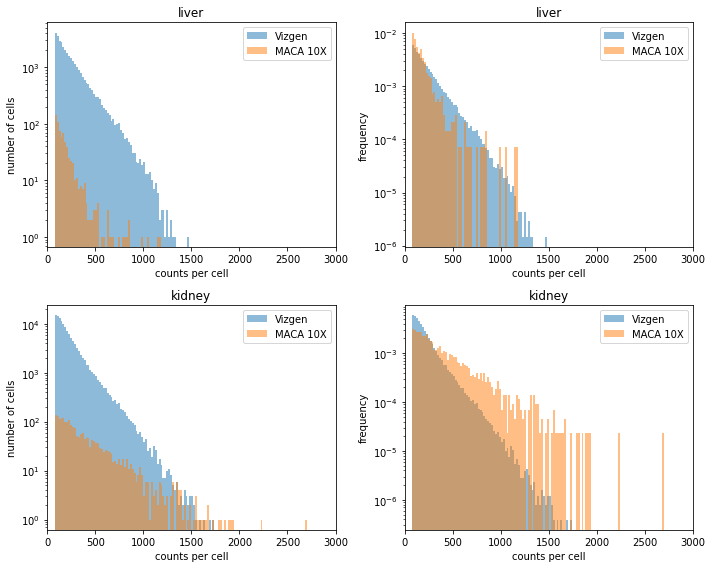

In [3]:
bins = np.arange(0,3000,20)
fig, axes = plt.subplots(2,2, figsize=(10,8))

counts_VizgenLiver = VizgenLiver.X.sum(axis=1)
counts_MACAliver_10x = MACAliver_10x.X.sum(axis=1)
counts_VizgenKidney = VizgenKidney.X.sum(axis=1)
counts_MACAkidney_10x = MACAkidney_10x.X.sum(axis=1)

# liver
ax = axes[0,0]
ax.hist(counts_VizgenLiver,alpha=0.5,bins=bins,label='Vizgen')
ax.hist(counts_MACAliver_10x,alpha=0.5,bins=bins,label='MACA 10X')
ax.set_xlabel('counts per cell')
ax.set_ylabel('number of cells')
ax.set_xlim((0,3000))
ax.set_yscale('log')
ax.legend()
ax.set_title('liver')

ax = axes[0,1]
ax.hist(counts_VizgenLiver,alpha=0.5,density=True,bins=bins,label='Vizgen')
ax.hist(counts_MACAliver_10x,alpha=0.5,density=True,bins=bins,label='MACA 10X')
ax.set_xlabel('counts per cell')
ax.set_ylabel('frequency')
ax.set_xlim((0,3000))
ax.set_yscale('log')
ax.legend()
ax.set_title('liver')

# kidney
ax = axes[1,0]
ax.hist(counts_VizgenKidney,alpha=0.5,bins=bins,label='Vizgen')
ax.hist(counts_MACAkidney_10x,alpha=0.5,bins=bins,label='MACA 10X')
ax.set_xlabel('counts per cell')
ax.set_ylabel('number of cells')
ax.set_xlim((0,3000))
ax.set_yscale('log')
ax.legend()
ax.set_title('kidney')

ax = axes[1,1]
ax.hist(counts_VizgenKidney,alpha=0.5,density=True,bins=bins,label='Vizgen')
ax.hist(counts_MACAkidney_10x,alpha=0.5,density=True,bins=bins,label='MACA 10X')
ax.set_xlabel('counts per cell')
ax.set_ylabel('frequency')
ax.set_xlim((0,3000))
ax.set_yscale('log')
ax.legend()
ax.set_title('kidney')

fig.tight_layout()
plt.show()

### Panel C, D: dropout rates/n_genes for each technology

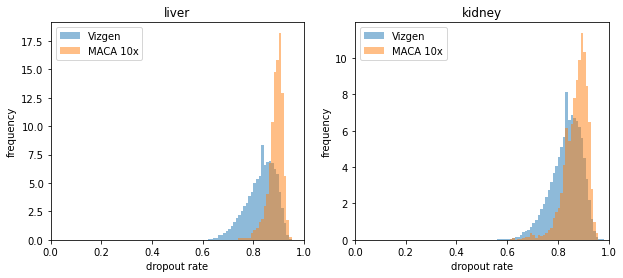

In [4]:
# Number of genes that have zero count for each cell divided by total number of genes in panel
n_genes = VizgenLiver.shape[1]
VizgenLiverDropoutFrac = 1 - np.count_nonzero(VizgenLiver.X.toarray(), axis=1) / n_genes
VizgenKidneyDropoutFrac = 1 - np.count_nonzero(VizgenKidney.X.toarray(), axis=1) / n_genes
MACALiverDropoutFrac_10x = 1 - np.count_nonzero(MACAliver_10x.X.toarray(), axis=1) / n_genes
MACAKidneyDropoutFrac_10x = 1 - np.count_nonzero(MACAkidney_10x.X.toarray(), axis=1) / n_genes

# Plot the dropout rate
bins = np.arange(0,1,0.01)
fig, axes = plt.subplots(1,2, figsize=(10,4))

ax = axes[0]
ax.hist(VizgenLiverDropoutFrac,alpha=0.5,density=True,bins=bins,label='Vizgen')
ax.hist(MACALiverDropoutFrac_10x,alpha=0.5,density=True,bins=bins,label='MACA 10x')
ax.set_xlabel('dropout rate')
ax.set_ylabel('frequency')
ax.set_xlim((0,1))
ax.set_title('liver')
ax.legend()

ax = axes[1]
ax.hist(VizgenKidneyDropoutFrac,alpha=0.5,density=True,bins=bins,label='Vizgen')
ax.hist(MACAKidneyDropoutFrac_10x,alpha=0.5,density=True,bins=bins,label='MACA 10x')
ax.set_xlabel('dropout rate')
ax.set_ylabel('frequency')
ax.set_xlim((0,1))
ax.set_title('kidney')
ax.legend()

plt.show()

### Panel E, F: scatter plot of fraction of cells detecting each gene between 10x and Vizgen

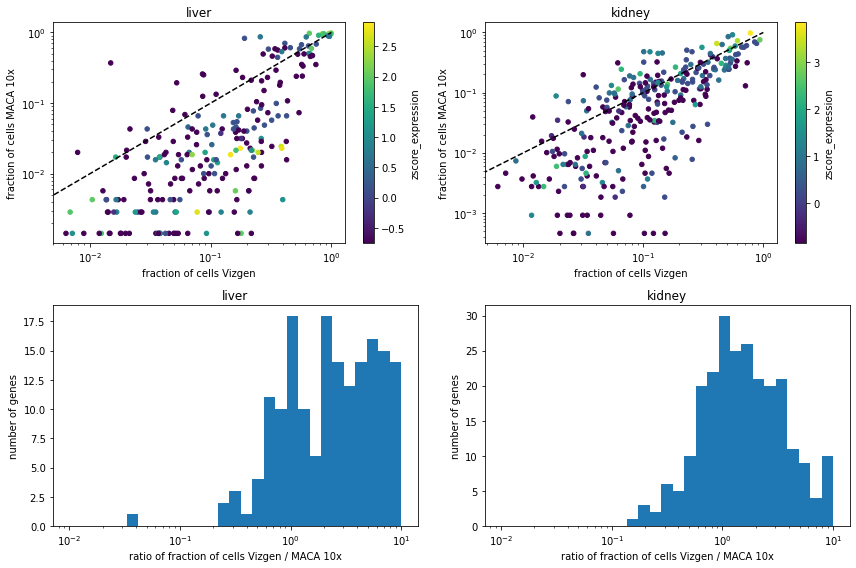

In [5]:
# Fraction of cells detecting a gene
# Do this in a joint DataFrame to ensure gene mapping are the same

frac_cells_VizgenLiver = VizgenLiver.to_df().astype(bool).sum(axis=0) / len(VizgenLiver)
frac_cells_VizgenKidney = VizgenKidney.to_df().astype(bool).sum(axis=0) / len(VizgenKidney)
frac_cells_MACAliver_10x = MACAliver_10x.to_df().astype(bool).sum(axis=0) / len(MACAliver_10x)
frac_cells_MACAkidney_10x = MACAkidney_10x.to_df().astype(bool).sum(axis=0) / len(MACAkidney_10x)

# Log median expression ignoring zeros
median_expression_liver = np.log(MACAliver_10x.to_df()[MACAliver_10x.to_df() != 0].median(axis=0))
median_expression_kidney = np.log(MACAkidney_10x.to_df()[MACAkidney_10x.to_df() != 0].median(axis=0))

# Z score of log median expression
zscore_expression_liver = (median_expression_liver - 
                           median_expression_liver.mean()) / median_expression_liver.std()
zscore_expression_kidney = (median_expression_kidney - 
                            median_expression_kidney.mean()) / median_expression_kidney.std()

frac_cells_liver = pd.concat([frac_cells_VizgenLiver, frac_cells_MACAliver_10x, 
                              median_expression_liver, zscore_expression_liver], axis=1)
frac_cells_liver = frac_cells_liver.rename(columns={0:'MERFISH', 1:'scRNA-seq', 
                                                    2:'median_expression', 3:'zscore_expression'})
frac_cells_kidney = pd.concat([frac_cells_VizgenKidney, frac_cells_MACAkidney_10x, 
                               median_expression_kidney, zscore_expression_kidney], axis=1)
frac_cells_kidney = frac_cells_kidney.rename(columns={0:'MERFISH', 1:'scRNA-seq', 
                                                      2:'median_expression', 3:'zscore_expression'})

# Ratio of Vizgen to 10x
ratio_cells_liver = frac_cells_liver['MERFISH'] / frac_cells_liver['scRNA-seq']
ratio_cells_kidney = frac_cells_kidney['MERFISH'] / frac_cells_kidney['scRNA-seq']

fig, axes = plt.subplots(2,2, figsize=(12,8))

# liver
ax = axes[0,0]
frac_cells_liver.plot.scatter('MERFISH','scRNA-seq', c='zscore_expression', colormap='viridis', colorbar=True, ax=ax)
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('fraction of cells Vizgen')
ax.set_ylabel('fraction of cells MACA 10x')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('liver')

# kidney
ax = axes[0,1]
frac_cells_kidney.plot.scatter('MERFISH','scRNA-seq', c='zscore_expression', colormap='viridis', colorbar=True, ax=ax)
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('fraction of cells Vizgen')
ax.set_ylabel('fraction of cells MACA 10x')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('kidney')

# liver ratio
ax = axes[1,0]
bins = np.logspace(-2,1,30)
ax.hist(ratio_cells_liver, density=False, bins=bins)
ax.set_xscale('log')
ax.set_xlabel('ratio of fraction of cells Vizgen / MACA 10x')
ax.set_ylabel('number of genes')
ax.set_title('liver')

# kidney ratio
ax = axes[1,1]
bins = np.logspace(-2,1,30)
ax.hist(ratio_cells_kidney, density=False, bins=bins)
ax.set_xscale('log')
ax.set_xlabel('ratio of fraction of cells Vizgen / MACA 10x')
ax.set_ylabel('number of genes')
ax.set_title('kidney')

fig.tight_layout()
plt.show()

### Panel G, H: leakiness of each technology
- get a list of pancreas genes and make a bar plot of mean expression for each gene for Vizgen vs MACA 10x

/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


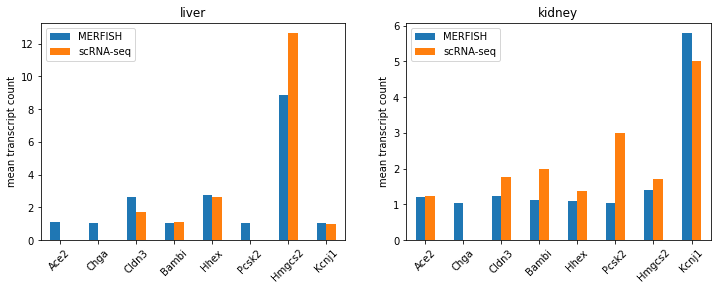

In [6]:
pancreas_genes = ['ace2','chga','cldn3','bambi',
                 'hhex','pcsk2']

liver_genes = 'hmgcs2'
kidney_genes = 'kcnj1'

all_genes = pancreas_genes.copy()
all_genes.append(liver_genes)
all_genes.append(kidney_genes)

# Get subset of pancreas genes
VizgenLiver_pancreas = VizgenLiver[:, all_genes]
VizgenKidney_pancreas = VizgenKidney[:, all_genes]
MACAliver_10x_pancreas = MACAliver_10x[:, all_genes]
MACAkidney_10x_pancreas = MACAkidney_10x[:, all_genes]

# Calculate mean + SD expression for these genes for cells with nonzero expression
mean_VizgenLiver_pancreas = VizgenLiver_pancreas.to_df()[VizgenLiver_pancreas.to_df() != 0].mean(axis=0)
mean_VizgenKidney_pancreas = VizgenKidney_pancreas.to_df()[VizgenKidney_pancreas.to_df() != 0].mean(axis=0)
mean_MACAliver_10x_pancreas = MACAliver_10x_pancreas.to_df()[MACAliver_10x_pancreas.to_df() != 0].mean(axis=0)
mean_MACAkidney_10x_pancreas = MACAkidney_10x_pancreas.to_df()[MACAkidney_10x_pancreas.to_df() != 0].mean(axis=0)

se_VizgenLiver_pancreas = VizgenLiver_pancreas.to_df()[
    VizgenLiver_pancreas.to_df() != 0].std(axis=0) / np.sqrt(len(VizgenLiver))
se_VizgenKidney_pancreas = VizgenKidney_pancreas.to_df()[
    VizgenKidney_pancreas.to_df() != 0].std(axis=0) / np.sqrt(len(VizgenKidney))
se_MACAliver_10x_pancreas = MACAliver_10x_pancreas.to_df()[
    MACAliver_10x_pancreas.to_df() != 0].std(axis=0) / np.sqrt(len(MACAliver_10x))
se_MACAkidney_10x_pancreas = MACAkidney_10x_pancreas.to_df()[
    MACAkidney_10x_pancreas.to_df() != 0].std(axis=0) / np.sqrt(len(MACAkidney_10x))

mean_liver_pancreas = pd.concat([mean_VizgenLiver_pancreas, mean_MACAliver_10x_pancreas],
                               axis=1)
mean_liver_pancreas = mean_liver_pancreas.rename(columns={0:'MERFISH', 1:'scRNA-seq'})
mean_kidney_pancreas = pd.concat([mean_VizgenKidney_pancreas, mean_MACAkidney_10x_pancreas],
                               axis=1)
mean_kidney_pancreas = mean_kidney_pancreas.rename(columns={0:'MERFISH', 1:'scRNA-seq'})

se_liver_pancreas = pd.concat([se_VizgenLiver_pancreas, se_MACAliver_10x_pancreas],
                             axis=1)
se_liver_pancreas = se_liver_pancreas.rename(columns={0:'MERFISH', 1:'scRNA-seq'})
se_kidney_pancreas = pd.concat([se_VizgenKidney_pancreas, se_MACAkidney_10x_pancreas],
                             axis=1)
se_kidney_pancreas = se_kidney_pancreas.rename(columns={0:'MERFISH', 1:'scRNA-seq'})

# Capitalize the genes
mean_liver_pancreas.index = mean_liver_pancreas.index.str.capitalize()
mean_kidney_pancreas.index = mean_kidney_pancreas.index.str.capitalize()

# Plot
fig, axes = plt.subplots(1,2, figsize=(12,4))

# liver
ax = axes[0]
mean_liver_pancreas.plot.bar(ax=ax, yerr=se_liver_pancreas, rot=45, capsize=2)
ax.set_ylabel('mean transcript count')
ax.set_title('liver')

# kidney
ax = axes[1]
mean_kidney_pancreas.plot.bar(ax=ax, yerr=se_kidney_pancreas, rot=45, capsize=2)
ax.set_ylabel('mean transcript count')
ax.set_title('kidney')

plt.show()

### Plot the combined figure

/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_methods.py:43: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/data01/jonathan.liu/miniconda3/envs/jupyter/lib/python3.9/site-packages/numpy/core/_methods.py:39: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


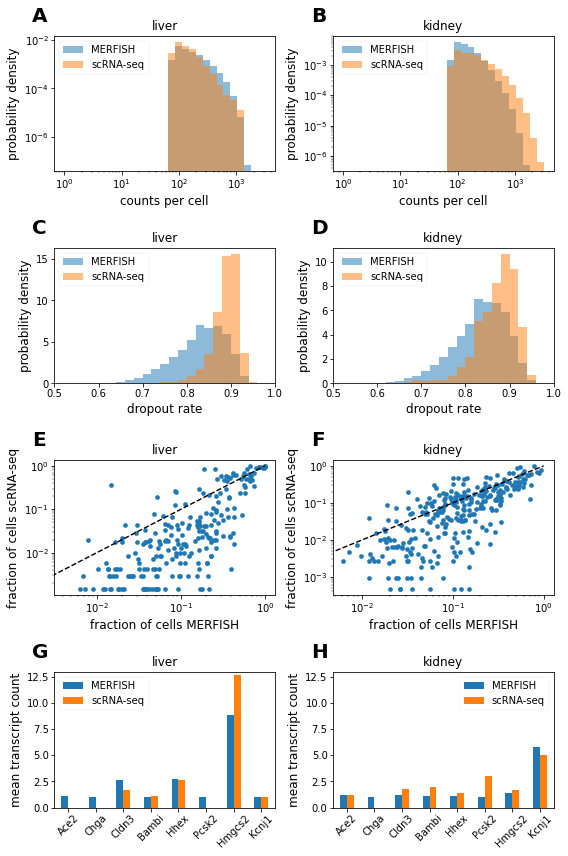

In [7]:
# Plot the whole figure
# Ignore the SmartSeq2 data for now

set_plotting_style()

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(8,12)) #Create a grid


# # Inset
# # barplots
# ax1 = ax[0].inset_axes([2, -9, 6, 4], transform=ax[0].transData)
# x_bar = [4,5]
# y_bar = [coord_df.loc[('liver','heart'),'macrophage'], coord_control_df_mean.loc[('liver','heart'),'macrophage']]
# y_err = [0, coord_control_df_sd.loc[('liver','heart'),'macrophage']]
# colors = ['tab:blue','tab:gray']

# ax1.bar(x_bar, y_bar, yerr=y_err, width=0.5, capsize=4, color=colors)
# ax1.set_ylim((0,1))
# ax1.set_yticks([0,1])
# #ax1.legend()


# Panel A: liver counts/cell comparison
#bins = np.arange(0,3000,20)
bins = np.logspace(0,3.5,30)
ax = axes[0,0]
ax.hist(counts_VizgenLiver,alpha=0.5,density=True,bins=bins,label='MERFISH')
ax.hist(counts_MACAliver_10x,alpha=0.5,density=True,bins=bins,label='scRNA-seq')
ax.set_xlabel('counts per cell')
ax.set_ylabel('probability density')
#ax.set_xlim((0,3000))
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_title('liver')

# Panel B: kidney counts/cell comparison
ax = axes[0,1]
ax.hist(counts_VizgenKidney,alpha=0.5,density=True,bins=bins,label='MERFISH')
ax.hist(counts_MACAkidney_10x,alpha=0.5,density=True,bins=bins,label='scRNA-seq')
ax.set_xlabel('counts per cell')
ax.set_ylabel('probability density')
#ax.set_xlim((0,3000))
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_title('kidney')

# Panel C: liver dropout rate
bins = np.arange(0.5,1,0.02)

ax = axes[1,0]
ax.hist(VizgenLiverDropoutFrac,alpha=0.5,density=True,bins=bins,label='MERFISH')
ax.hist(MACALiverDropoutFrac_10x,alpha=0.5,density=True,bins=bins,label='scRNA-seq')
ax.set_xlabel('dropout rate')
ax.set_ylabel('probability density')
ax.set_xlim((0.5,1))
ax.set_title('liver')
ax.legend()

# Panel D: kidney dropout rate
ax = axes[1,1]
ax.hist(VizgenKidneyDropoutFrac,alpha=0.5,density=True,bins=bins,label='MERFISH')
ax.hist(MACAKidneyDropoutFrac_10x,alpha=0.5,density=True,bins=bins,label='scRNA-seq')
ax.set_xlabel('dropout rate')
ax.set_ylabel('probability density')
ax.set_xlim((0.5,1))
ax.set_title('kidney')
ax.legend()

# Panel E: liver cells/gene
ax = axes[2,0]
frac_cells_liver.plot.scatter('MERFISH','scRNA-seq', ax=ax)
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('fraction of cells MERFISH')
ax.set_ylabel('fraction of cells scRNA-seq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('liver')

# Panel F: kidney cells/gene
ax = axes[2,1]
frac_cells_kidney.plot.scatter('MERFISH','scRNA-seq', ax=ax)
ax.plot([0,1],[0,1],'k--')
ax.set_xlabel('fraction of cells MERFISH')
ax.set_ylabel('fraction of cells scRNA-seq')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('kidney')

# Panel G: liver leakiness
ax = axes[3,0]
mean_liver_pancreas.plot.bar(ax=ax, yerr=se_liver_pancreas, rot=45, capsize=4)
ax.set_ylim(0,13)
ax.set_ylabel('mean transcript count')
ax.set_title('liver')

# Panel H: kidney leakiness
ax = axes[3,1]
mean_kidney_pancreas.plot.bar(ax=ax, yerr=se_kidney_pancreas, rot=45, capsize=4)
ax.set_ylim(0,13)
ax.set_ylabel('mean transcript count')
ax.set_title('kidney')

# Label subpanels
axes_label = [axes[0,0], axes[0,1], axes[1,0], axes[1,1],
              axes[2,0], axes[2,1], axes[3,0], axes[3,1]]
for n, ax in enumerate(axes_label):
    ax.text(-0.1, 1.1, string.ascii_uppercase[n], transform=ax.transAxes, 
                size=20, weight='bold')

fig.tight_layout()
plt.show()

In [8]:
# Export figures
fig.savefig('../../figures/Fig4_singlecellcomparison.svg', transparent=True)
fig.savefig('../../figures/Fig4_singlecellcomparison.png', transparent=True)

print('Figures saved.')

Figures saved.
